#Modelo de Aprendizaje Automático - Credit Card Fraud Project


##Descripción del modelo
Para la solución de este reto, se optó por implementar un modelo 

##Tarea: **Clasificación**
Tarea de aprendizaje supervisado que con base en determinadas características, determina la clase a la que pertenece el objeto. Es decir, aunque el objeto tal cual no esté en las clases, lo clasifica en la clase con la cual comparta mayor número de características. Este tipo de algoritmos lo que hacen es aprender del "label" asignado a los datos de entrenamiento para, mediante la asociación de patrones, poder etiquetar los nuevos datos.

Se optó por esta tarea porque es fácil identificar el alcance de nuestro modelo,y el cómo desempeñará su tarea. Para nuestro caso tenemos solo dos posibilidades, la transacción es o no fraude, por lo que es un tipo de clasificación binaria. Es fácil evaluar la efectividad del mismo, así como identificar cuando el modelo ya está listo y podemos detener el entrenamiento del mismo.

##Técnica: **Árboles de decisión** 
Técnica de aprendizaje automático que crea el modelo con base en reglas, y estas reglas pueden ser fácilmente entendidas por el usuario. Lo podemos entender como un conjunto de condicionales las cuales con base en las características,  colocadas en el nodo de decisión, determina la clase a la que pertenence el objeto, ubicada en el nodo terminal.

Se optó por esta ténica porque este modelo puede manejar tanto características numéricas como nominales, y en nuestra base de datos tenemos ambas. Debido a la representación visual de estos, es fácil observar las relaciones de causa y efecto y a su vez la comprensión del funcionamiento es más sencilla para nosotros como usuario. Los datos utilizados para la creación de este tipo de modelo no necesitan de mucha preparación, lo cual también facilita su implementación. Y la razón más fuerte por la que decidimos usar este modelo es porque toma las mejor decisión de clasificación con base en información ya existente y de las mejores suposiciones.   

##Modelo

In [ ]:
# Librerias
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # librería para árboles de decisión
from sklearn.ensemble import RandomForestClassifier # librería para bosques aleatorios
from sklearn import tree # librería para poder visualizar el árbol
from sklearn.model_selection import GridSearchCV # librería para mejorar nuestros modelos
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

Vamos a obtener nuestros datasets dentro de nuestro Drive

In [ ]:
# Montamos los archivos de nuestro Drive para que puedan usarse en Colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Establecemos el directorio de la base de datos
BASE_DIR = '/content/drive/My Drive/BasesDeDatos/proyecto/'

Obtenemos los datasets

In [ ]:
#Cargamos la base de datos que se utilizará para entrenar el modelo
data_train = pd.read_csv(BASE_DIR + 'fraudTrainV2.csv')
#Visualización de la base de datos
data_train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,1/1/2019 00:00,2.703190e+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",9/3/1988,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1/1/2019 00:00,6.304230e+11,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,21/6/1978,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,1/1/2019 00:00,3.885950e+13,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,19/1/1962,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,1/1/2019 00:01,3.534090e+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,12/1/1967,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,1/1/2019 00:03,3.755340e+14,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,28/3/1986,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [ ]:
#Cargamos la base de datos que se utilizará para probar el modelo
data_test = pd.read_csv(BASE_DIR + 'fraudTest.csv', index_col=0)
#Visualización de la base de datos
data_test.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


Limpiamos nuestros datasets para que sean de tipo numéricos

In [ ]:
# Preparación de data de entrenamiento
# Reemplazamos datos tipo string a datos tipo int
data_train['gender'] = data_train['gender'].replace(['M', 'F'], [0, 1])
data_train['category'] = data_train['category'].replace(
    ['entertainment', 'food_dining', 'misc_net', 'grocery_pos', 'gas_transport', 
     'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos', 'personal_care', 
     'health_fitness', 'travel', 'kids_pets', 'home'], 
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
# Hacemos split para obtener la parte de mayor peso de la variable 'dob'
f = lambda x: x['dob'].split("/")[2]
data_train['dob'] = data_train.apply(f, axis=1)
# Dividimos la variable 'trans_date_trans_time' para obtener la hora (variable de interés)
data_train[['date', 'time']] = data_train.trans_date_trans_time.str.split(" ", expand=True,)
data_train = data_train.drop(['trans_date_trans_time', 'cc_num', 'merchant', 
                              'first', 'last', 'city', 'state', 'zip', 'street', 
                              'city_pop', 'job', 'trans_num', 'merch_lat', 
                              'merch_long', 'date'], axis = 1)
f = lambda x: x['time'].split(":")[0]
data_train['time'] = data_train.apply(f, axis=1)
# Acomodamos columna 'is_fraud' al final
data_train = data_train[[c for c in data_train if c not in ['is_fraud']] + ['is_fraud']]
# Imprimimos head()
data_train.head()


,category,amt,gender,lat,long,dob,unix_time,time,is_fraud
0,3,4.97,1,36.0788,-81.1781,1988,1325376018,00,0
1,4,107.23,1,48.8878,-118.2105,1978,1325376044,00,0
2,1,220.11,0,42.1808,-112.2620,1962,1325376051,00,0
3,5,45.00,0,46.2306,-112.1138,1967,1325376076,00,0
4,6,41.96,0,38.4207,-79.4629,1986,1325376186,00,0


Obtenemos los mejores parámetros para el árbol de decisión con GridSearchCV

In [ ]:
# Data de entrenamiento
x_train = data_train.drop('is_fraud', axis = 1)
y_train = data_train['is_fraud']
# Parámetros
params = {'criterion' : ['gini', 'entropy'],
          'splitter' : ['best', 'random']}
#Configuración de la rejilla
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state = 42), params, verbose = 1, cv = 2, n_jobs = 8, scoring = 'accuracy')
#se hacen todas las combinaciones posibles y se queda con el que tiene el mejor resultado en el "accuracy"
#Generación de los modelos 
grid_search_cv.fit(x_train, y_train)
#Visualizamos la mejor configuración para el modelo
print(grid_search_cv.best_estimator_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   19.0s remaining:   57.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   29.5s finished


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='random')


In [ ]:
#Visualización de la configuración elegida como la mejor
dt_mejorado = grid_search_cv.best_estimator_
dt_mejorado.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'random'}

Limpiamos dataset de testeo para evaluar modelo entrenado

In [ ]:
# Preparación de datos test
data_test['gender'] = data_test['gender'].replace(['M', 'F'], [0, 1])
data_test['category'] = data_test['category'].replace(['entertainment', 'food_dining', 'misc_net', 'grocery_pos', 'gas_transport', 'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos', 'personal_care', 'health_fitness', 'travel', 'kids_pets', 'home'], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
f = lambda x: x['dob'].split("-")[0]
data_test['dob'] = data_test.apply(f, axis=1)
data_test[['date', 'time']] = data_test.trans_date_trans_time.str.split(" ", expand=True,)
data_test = data_test.drop(['trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 'city', 'state', 'zip', 'street', 'city_pop', 'job', 'trans_num', 'merch_lat', 'merch_long', 'date'], axis = 1)
f = lambda x: x['time'].split(":")[0]
data_test['time'] = data_test.apply(f, axis=1)
data_test = data_test[[c for c in data_test if c not in ['is_fraud']] + ['is_fraud']]
data_train.head()

,category,amt,gender,lat,long,dob,unix_time,time,is_fraud
0,3,4.97,1,36.0788,-81.1781,1988,1325376018,00,0
1,4,107.23,1,48.8878,-118.2105,1978,1325376044,00,0
2,1,220.11,0,42.1808,-112.2620,1962,1325376051,00,0
3,5,45.00,0,46.2306,-112.1138,1967,1325376076,00,0
4,6,41.96,0,38.4207,-79.4629,1986,1325376186,00,0


Hacemos un test del mejor modelo

In [ ]:
# Data test
x_test = data_test.drop('is_fraud', axis = 1)
y_test = data_test['is_fraud']
# Prueba del modelo mejorado con lo obtenido en el paso anterior
dt_mejorado.score(x_test, y_test)

0.997667886107907

In [ ]:
predictions = dt_mejorado.predict(x_test)
# print("Score : \n", accuracy_score(y_test, predictions))

In [ ]:
print("Confusion Matrix : \n", confusion_matrix(y_test, predictions))
fpr, tpr, thresholds = roc_curve(y_test, predictions)
print("AUC : \n", auc(fpr, tpr))

Confusion Matrix : 
 [[552791    783]
 [   513   1632]]
AUC : 
 0.8797123578982916


Representación gráfica de nuestro árbol de decisión

[Text(149.16706251011698, 214.57894736842104, 'X[0] <= 10.452\nentropy = 0.051\nsamples = 1048575\nvalue = [1042569, 6006]'),
 Text(61.10982025917428, 208.85684210526315, 'X[7] <= 1.985\nentropy = 0.062\nsamples = 755401\nvalue = [749946, 5455]'),
 Text(9.649131364672142, 203.13473684210527, 'X[0] <= 4.557\nentropy = 0.114\nsamples = 69169\nvalue = [68109, 1060]'),
 Text(5.451984785683417, 197.41263157894736, 'X[5] <= 1994.58\nentropy = 0.153\nsamples = 27315\nvalue = [26712, 603]'),
 Text(3.1827736416139554, 191.69052631578947, 'X[2] <= 0.195\nentropy = 0.137\nsamples = 26727\nvalue = [26214, 513]'),
 Text(1.7231289042549014, 185.96842105263158, 'X[1] <= 215.105\nentropy = 0.154\nsamples = 12486\nvalue = [12207, 279]'),
 Text(1.6178996581935332, 180.24631578947367, 'entropy = 0.0\nsamples = 11954\nvalue = [11954, 0]'),
 Text(1.8283581503162694, 180.24631578947367, 'X[0] <= 3.604\nentropy = 0.998\nsamples = 532\nvalue = [253, 279]'),
 Text(0.9207559030369702, 174.52421052631578, 'X[0] 

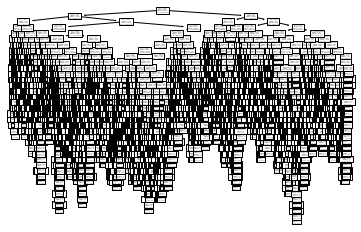

In [ ]:
tree.plot_tree(dt_mejorado)

In [ ]:
# Parámetros
params = {'criterion' : ['gini', 'entropy']}
#Configuración de la rejilla
grid_search_cv = GridSearchCV(RandomForestClassifier(random_state = 42), params, verbose = 1, cv = 2, n_jobs = 8, scoring = 'accuracy')
#se hacen todas las combinaciones posibles y se queda con el que tiene el mejor resultado en el "accuracy"
#Generación de los modelos 
grid_search_cv.fit(x_train, y_train)
#Visualizamos la mejor configuración para el modelo
print(grid_search_cv.best_estimator_)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:  4.5min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [ ]:
#Visualización de la configuración elegida como la mejor
dt_mejorado = grid_search_cv.best_estimator_
dt_mejorado.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Data test
x_test = data_test.drop('is_fraud', axis = 1)
y_test = data_test['is_fraud']
# Prueba del modelo mejorado con lo obtenido en el paso anterior
dt_mejorado.score(x_test, y_test)

0.9987331727005915

In [ ]:
predictions = dt_mejorado.predict(x_test)
# print("Score : \n", accuracy_score(y_test, predictions))

In [ ]:
print("Confusion Matrix : \n", confusion_matrix(y_test, predictions))
fpr, tpr, thresholds = roc_curve(y_test, predictions)
print("AUC : \n", auc(fpr, tpr))

Confusion Matrix : 
 [[553492     82]
 [   622   1523]]
AUC : 
 0.854937590839566
